In [1]:
!pip install torch torchvision opencv-python matplotlib albumentations scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
model.fc = torch.nn.Identity()  # Убираем последний слой
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
aug_pipeline = A.Compose([
    A.RandomRotate90(p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.RandomScale(scale_limit=0.15, p=0.4)
])

In [7]:
def generate_augmented_embeddings(image_path, num_aug=10):
    """Генерирует эмбеддинги для оригинала и аугментированных версий"""
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    embeddings = []

    # Оригинальное изображение
    with torch.no_grad():
        orig_tensor = preprocess(image).unsqueeze(0)
        embeddings.append(model(orig_tensor).numpy())

    # Аугментированные версии
    for _ in range(num_aug):
        augmented = aug_pipeline(image=image)['image']
        with torch.no_grad():
            aug_tensor = preprocess(augmented).unsqueeze(0)
            embeddings.append(model(aug_tensor).numpy())

    return np.mean(embeddings, axis=0)

In [8]:
reference_paths = [
    "logo1.png",
    "logo2.png"
]


In [9]:
reference_embeddings = []
for el in [generate_augmented_embeddings(path, 100) for path in reference_paths]:
    for _ in el:
        reference_embeddings.append(_)

In [10]:
def verify_logo(input_path, threshold=0.85):
    """Проверяет, соответствует ли логотип эталонам"""
    # Загрузка и препроцессинг
    image = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    input_tensor = preprocess(image).unsqueeze(0)
    print("image read!")

    # Извлечение признаков
    with torch.no_grad():
        input_embedding = model(input_tensor).numpy()
    print("embedding generated!")

    # Расчет сходства
    similarities = cosine_similarity(input_embedding, reference_embeddings)
    max_similarity = np.max(similarities)
    print("similarities calculated!")

    # Визуализация
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Similarity: {max_similarity:.2f}\n{'MATCH' if max_similarity > threshold else 'NO MATCH'}")
    plt.axis('off')
    plt.show()

    return max_similarity > threshold

image read!
embedding generated!
similarities calculated!


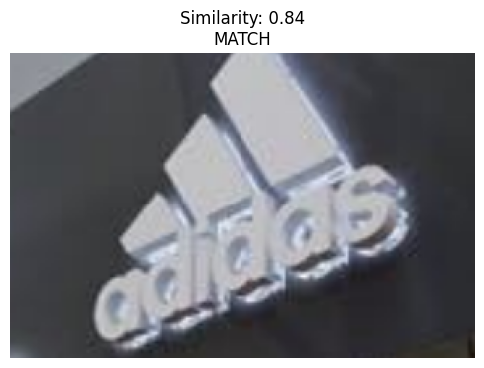

Результат: Принадлежит организации


In [16]:
test_image_path = "logo9.png"  # Ваше тестовое изображение
is_match = verify_logo(test_image_path, threshold=0.82)
print(f"Результат: {'Принадлежит организации' if is_match else 'Чужой логотип'}")